In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


fetch_housing_data()


import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing = strat_train_set.drop("median_house_value", axis=1)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop("ocean_proximity", axis=1)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.3s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.7s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.5s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.0s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.5s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.2s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  11.5s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  11.4s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  11.5s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.5s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.4s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.3s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.1s
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.0min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.2min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.2min
[CV] END C=151136.2028

[CV] END C=60.17373642891687, gamma=1.2491263443165994, kernel=linear; total time=   5.9s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.0s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.0s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.0s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.0s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.0s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.5s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.4s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.4s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.5s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.4s
[CV] END C=55.538389

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2107a77250>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2104250c10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [6]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

55215.34140493225

In [7]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

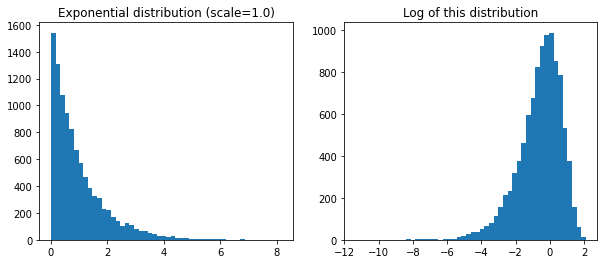

In [8]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

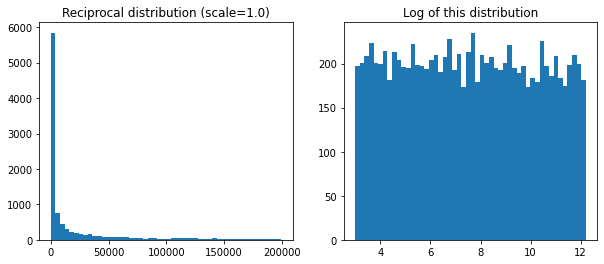

In [9]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()